In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Import Dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import median_absolute_error, PredictionErrorDisplay
from sklearn.feature_selection import SelectKBest, f_regression, RFECV

from xgboost.sklearn import XGBRegressor


# 1. Data preparation

In [ ]:
# If using local machine
df = pd.read_csv('Punching Shear Clean.csv')

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Punching/Punching Shear Clean.csv')
df.head()

,Shape,b1 (mm),d1 (mm),davg (mm),ravg,b* (mm),b*/davg,fc (MPa),fy (MPa),Pu (kN)
0,C,51,NaN,38.100,0.020138,39.898227,1.047198,13.145888,550,24
1,S,76,NaN,29.972,0.017700,76.200000,2.542373,26.332005,396,31
2,C,102,NaN,38.100,0.020138,79.796453,2.094395,13.145888,550,33
3,S,76,NaN,31.750,0.009800,76.200000,2.400000,28.008869,332,34
4,C,102,NaN,38.100,0.020138,79.796453,2.094395,13.145888,550,34


**Shape** of the column cross section: 'S' = square; 'C' = circular; 'R' = rectangular

**b1** - Column side or smaller side if Shape = 'R' (mm)

**d1** - Larger side of the column if Shape = 'R' (mm)

**davg** - Average effective depth in X and Y directions (mm)

**ravg** - Average reinforcement ratio in X and Y directions

**b*** - Column effective width (mm) - alternative to Shape, b1 and d1

**b*/davg** - Effective width / effective depth

**fc** - Concrete compressive strength (MPa)

**fy** - Steel yield strength (MPa)

**Pu** - Punching shear resistance (kN)



In [5]:
df.isna().sum()

,0
Shape,0
b1 (mm),0
d1 (mm),395
davg (mm),0
ravg,0
b* (mm),0
b*/davg,0
fc (MPa),0
fy (MPa),0
Pu (kN),0


In [6]:
df_na = df[df.isna().any(axis=1)].copy()
df_na

,Shape,b1 (mm),d1 (mm),davg (mm),ravg,b* (mm),b*/davg,fc (MPa),fy (MPa),Pu (kN)
0,C,51,NaN,38.100,0.020138,39.898227,1.047198,13.145888,550,24
1,S,76,NaN,29.972,0.017700,76.200000,2.542373,26.332005,396,31
2,C,102,NaN,38.100,0.020138,79.796453,2.094395,13.145888,550,33
3,S,76,NaN,31.750,0.009800,76.200000,2.400000,28.008869,332,34
4,C,102,NaN,38.100,0.020138,79.796453,2.094395,13.145888,550,34
...,...,...,...,...,...,...,...,...,...,...
412,S,200,NaN,275.000,0.014875,200.000000,0.727273,83.490750,550,2250
413,S,200,NaN,275.000,0.025500,200.000000,0.727273,89.675250,550,2400
414,S,200,NaN,275.000,0.014875,200.000000,0.727273,111.720000,550,2450
415,S,300,NaN,500.000,0.007576,300.000000,0.600000,37.430000,433,2681


In [7]:
df_na_R = df_na[(df_na['Shape'] == 'R')]
df_na_R

,Shape,b1 (mm),d1 (mm),davg (mm),ravg,b* (mm),b*/davg,fc (MPa),fy (MPa),Pu (kN)


It means, that NaN are present only by Square and Cirucular shape. It will be handeld by Feature Engineering

Let's Check for duplicates

In [8]:
df.duplicated().sum()

1

It's irrelevant

# 2. Feature Engineering

### Feature 1 - Basic Controll Perimeter

In [9]:
# Basic controll perimeter according to Eurocode 2 --> 2d
# Assumption: puncture is centric and not at the slab edge

def bcp(shape,b1,d1,davg):
  if shape == 'C':
    return 2*math.pi*(b1/2+2*davg)
  if shape == 'S':
    return 4*b1+2*math.pi*2*davg
  if shape == 'R':
    return 2*b1+2*d1+2*math.pi*2*davg


In [10]:
# Apply
df['bcp (mm)'] = df.apply(lambda row: round(bcp(row['Shape'], row['b1 (mm)'], row['d1 (mm)'], row['davg (mm)']),0), axis=1)

In [11]:
df.columns

Index(['Shape', 'b1 (mm)', 'd1 (mm)', 'davg (mm)', 'ravg', 'b* (mm)',
       'b*/davg', 'fc (MPa)', 'fy (MPa)', 'Pu (kN)', 'bcp (mm)'],
      dtype='object')

In [12]:
df.head()

,Shape,b1 (mm),d1 (mm),davg (mm),ravg,b* (mm),b*/davg,fc (MPa),fy (MPa),Pu (kN),bcp (mm)
0,C,51,NaN,38.100,0.020138,39.898227,1.047198,13.145888,550,24,639.0
1,S,76,NaN,29.972,0.017700,76.200000,2.542373,26.332005,396,31,681.0
2,C,102,NaN,38.100,0.020138,79.796453,2.094395,13.145888,550,33,799.0
3,S,76,NaN,31.750,0.009800,76.200000,2.400000,28.008869,332,34,703.0
4,C,102,NaN,38.100,0.020138,79.796453,2.094395,13.145888,550,34,799.0


### Feature 2 - Reinforcement Area

In [13]:
def reinforcement_area(ravg,davg):
  return round(ravg * davg * 1000,0)

In [14]:
df['reinforcement_area (mm2)'] = df.apply(lambda row: reinforcement_area(row['ravg'],row['davg (mm)']),axis=1)

In [15]:
df.head()

,Shape,b1 (mm),d1 (mm),davg (mm),ravg,b* (mm),b*/davg,fc (MPa),fy (MPa),Pu (kN),bcp (mm),reinforcement_area (mm2)
0,C,51,NaN,38.100,0.020138,39.898227,1.047198,13.145888,550,24,639.0,767.0
1,S,76,NaN,29.972,0.017700,76.200000,2.542373,26.332005,396,31,681.0,531.0
2,C,102,NaN,38.100,0.020138,79.796453,2.094395,13.145888,550,33,799.0,767.0
3,S,76,NaN,31.750,0.009800,76.200000,2.400000,28.008869,332,34,703.0,311.0
4,C,102,NaN,38.100,0.020138,79.796453,2.094395,13.145888,550,34,799.0,767.0


# 3. EDA

Concrete punching is a failure mode in slab-column connections where a concentrated load causes a localized perforation, leading to potential collapse. The geometry features affecting punching resistance include the slab thickness, column dimensions, slab span, and especially the slab's reinforcement configuration. Adequate and well-designed reinforcement around the column region enhances the slab's ability to resist punching shear by distributing forces more effectively.

In [16]:
sns.set_theme(style="whitegrid", palette="pastel")

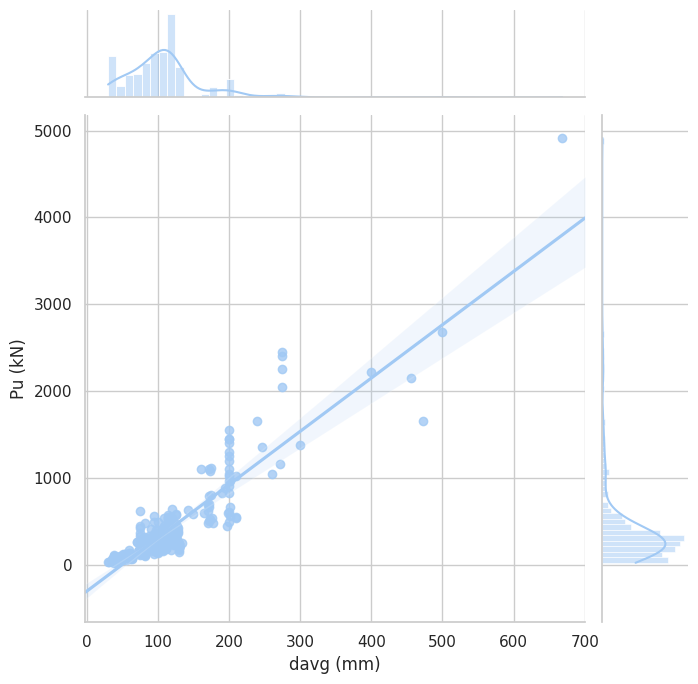

In [17]:
plot = sns.jointplot(data=df, x='davg (mm)', y='Pu (kN)',
                  kind="reg", truncate=False, height=7)

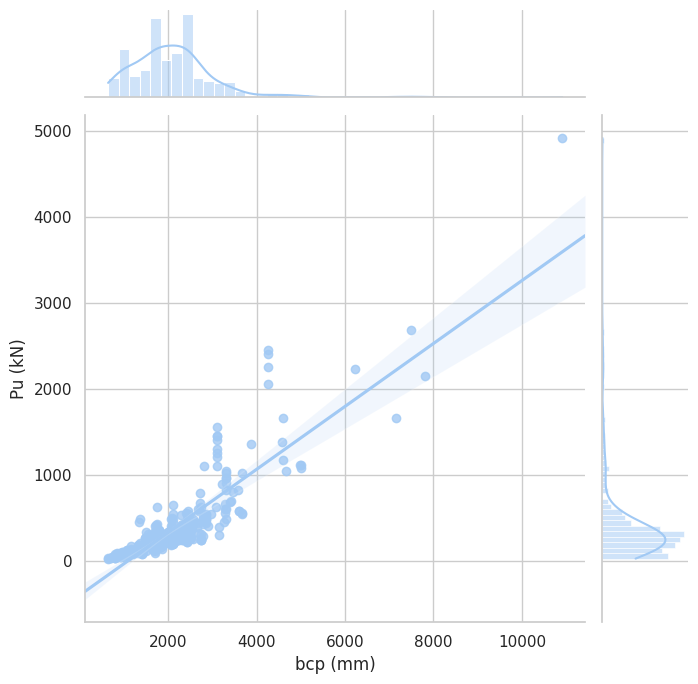

In [18]:
plot = sns.jointplot(data=df,  x='bcp (mm)', y='Pu (kN)',
                  kind="reg", truncate=False, height=7)

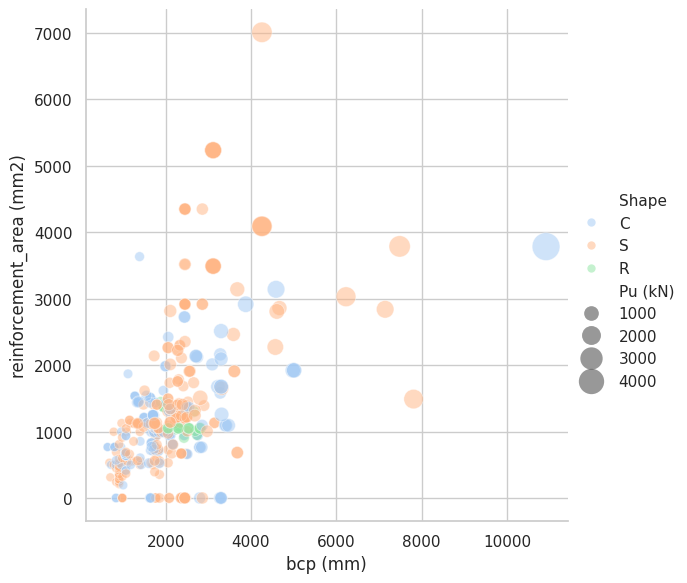

In [19]:
sns.relplot(data=df,  x='bcp (mm)', y='reinforcement_area (mm2)', hue='Shape', size='Pu (kN)',
            sizes=(40, 400), alpha=.5,
            height=6)

<Axes: >

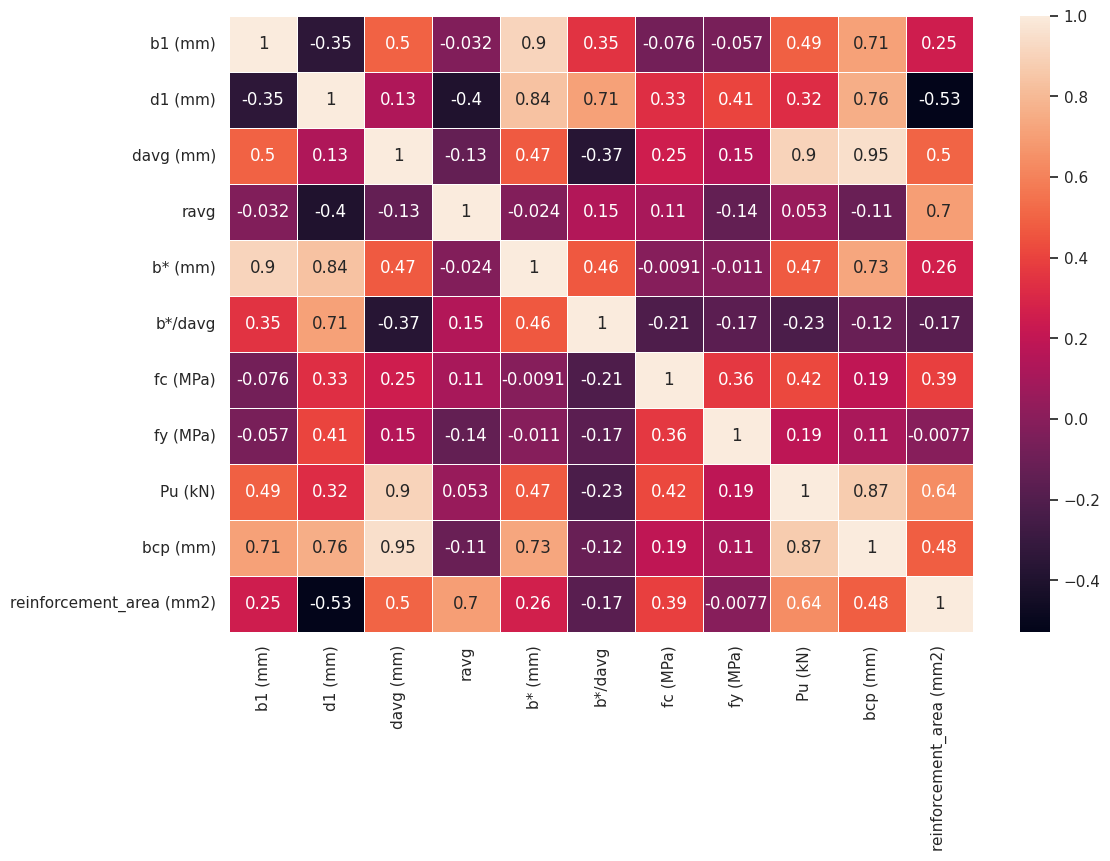

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.iloc[:,1:].corr(), annot=True, linewidths=.5, ax=ax)

As expected, the slab geometry features are correlated with each other as well as with the punching force. It is clear that the thicker the slab, or the greater the column dimensions in cross-section, the larger the basic control perimeter must be. This should allow the slab to handle a greater punching force. The same logic applies to the reinforcement cross-section—the greater it is, the higher the punching force capacity.

# 4. Regression Model

In the scientific literature (depending on the country), the problem of concrete punching is described using empirical formulas. When the formulas are combined into one, the problem takes the form of a polynomial of the n-th degree or a exponential function. The given data lacks information such as the rotation of the slab over the support, which is the basic parameter used to calculate the punching shear force according to Swiss SIA standards. In view of the above, and based on the graphs created during EDA, the n-th degree polynomial is assumed as a function that describes the problem accurately enough. N-degrees of freedom will be determined during Feature Engineering. The machine learning model that will deal with the described unknown function in the least complicated yet most efficient way will be the (non-)linear regression model.

In [21]:
# Preparations for Machine Learning
drop_columns = [
#  'Shape',
 'b1 (mm)', # in bcp
 'd1 (mm)', # in bcp
#  'davg (mm)',
 'ravg', # reinforcement_area
 'b* (mm)', # not clear how to interpret that value yet. strong corr with b1
 'b*/davg', # corr to b1 and davg
#  'fc (MPa)',
#  'fy (MPa)',
#  'Pu (kN)',
#  'bcp (mm)',
#  'reinforcement_area (mm2)'
                 ]


df_ml = df.drop(columns=drop_columns, axis=1)
df_ml.head()

,Shape,davg (mm),fc (MPa),fy (MPa),Pu (kN),bcp (mm),reinforcement_area (mm2)
0,C,38.100,13.145888,550,24,639.0,767.0
1,S,29.972,26.332005,396,31,681.0,531.0
2,C,38.100,13.145888,550,33,799.0,767.0
3,S,31.750,28.008869,332,34,703.0,311.0
4,C,38.100,13.145888,550,34,799.0,767.0


In [22]:
# Reorder Columns
reorder_columns = [
 'Shape',
 'davg (mm)',
 'bcp (mm)',
 'fc (MPa)',
 'fy (MPa)',
 'reinforcement_area (mm2)',
 'Pu (kN)',
                 ]

In [23]:
df_ml = df_ml[reorder_columns]
df_ml.head()

,Shape,davg (mm),bcp (mm),fc (MPa),fy (MPa),reinforcement_area (mm2),Pu (kN)
0,C,38.100,639.0,13.145888,550,767.0,24
1,S,29.972,681.0,26.332005,396,531.0,31
2,C,38.100,799.0,13.145888,550,767.0,33
3,S,31.750,703.0,28.008869,332,311.0,34
4,C,38.100,799.0,13.145888,550,767.0,34


## 4.1 Feature Importance

In [24]:
# Split Dataframe into Features (X) and Target (y)
X = df_ml.iloc[:,:-1]
y = df_ml.iloc[:,-1]

print(X.shape, y.shape)

(417, 6) (417,)


In [25]:
# Create Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [26]:
# Model definition
reg = LinearRegression()

**Feature selection - Univariate Feature Selection**

In [27]:
selector = SelectKBest(f_regression, k=2)
selector.fit(X_train.iloc[:,1:], y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

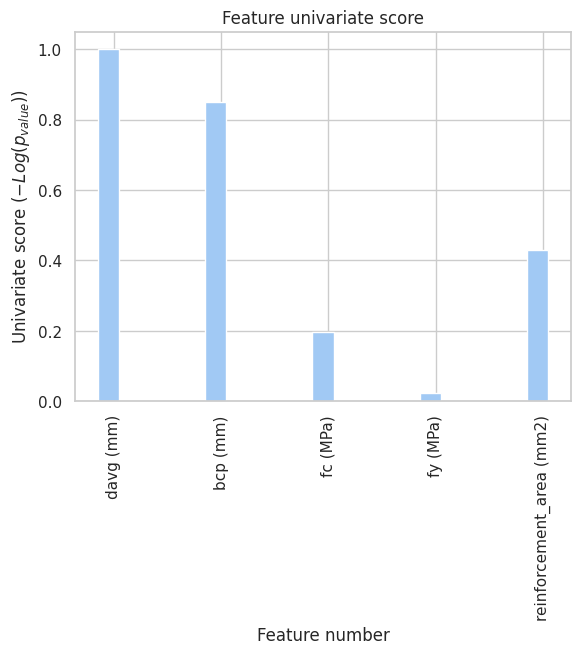

In [28]:
X_indices = np.arange(X.iloc[:,1:].shape[-1])
feature_names = X.iloc[:,1:].columns

plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.xticks(X_indices, feature_names, rotation=90)
plt.show()


According to Univariate Feature Selection method Shape of the Columns could not be taken into considereation

**Feature Selection - Recursive feature elimination with cross-validation**

In [29]:
min_features_to_select = 1  # Minimum number of features to consider
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=reg,
    step=1,
    cv=cv,
    scoring="explained_variance",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(X.iloc[:,1:], y)

print(f"Optimal number of features: {rfecv.n_features_}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Optimal number of features: 5


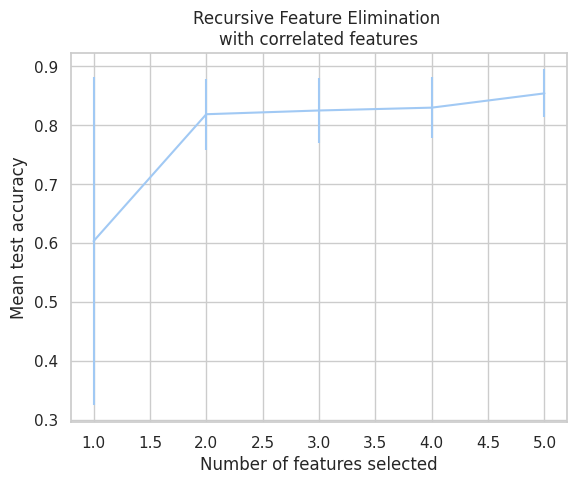

In [30]:
cv_results = pd.DataFrame(rfecv.cv_results_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results.index+1,
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

According to Recursive feature elimination with cross-validation method, all of the Features should be taken into consideration

## 4.2 Model Training

**Model Training**

In [31]:
# Dividing data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

# Split the data into categorical and numerical features
categorical_columns = ['Shape']
numerical_columns = [
 'davg (mm)',
 'fc (MPa)',
 'fy (MPa)',
 'bcp (mm)',
 'reinforcement_area (mm2)'
                 ]

# Checking whether columns exist in the data
missing_categorical = [col for col in categorical_columns if col not in X_train.columns]
missing_numerical = [col for col in numerical_columns if col not in X_train.columns]

if missing_categorical:
    raise ValueError(f"Brakujące kolumny kategoryczne: {missing_categorical}")
if missing_numerical:
    raise ValueError(f"Brakujące kolumny numeryczne: {missing_numerical}")


# Creating a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('OneHotEncoder', OneHotEncoder(drop='if_binary'), categorical_columns),
        ('Scaler', StandardScaler(), numerical_columns),
        ('PolyFeatures', PolynomialFeatures(degree=2, include_bias=False), numerical_columns)
    ]
)

# Create a pipeline with a more complex preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
    ]
)


# Defining preprocessor options
preprocessor_options = [
    ColumnTransformer(
        transformers=[
            ('OneHotEncoder', OneHotEncoder(drop='if_binary'), categorical_columns),
            ('Scaler', StandardScaler(), numerical_columns),
            ('PolyFeatures', PolynomialFeatures(2, include_bias=False), numerical_columns)
        ]
    ),
    ColumnTransformer(
        transformers=[
            ('OneHotEncoder', OneHotEncoder(drop='if_binary'), categorical_columns),
            ('Scaler', StandardScaler(), numerical_columns),
            ('PolyFeatures', PolynomialFeatures(3, include_bias=False), numerical_columns)
        ]
    ),
    ColumnTransformer(
        transformers=[
            ('OneHotEncoder', OneHotEncoder(drop='if_binary'), categorical_columns),
            ('Scaler', StandardScaler(), numerical_columns)
        ]
    )
]


# Defining regressors and their parameters
regressor_options = [
    (LinearRegression(n_jobs=-1), {}),
    (GradientBoostingRegressor(random_state=25),
              {'n_estimators' : list(range(10,101,10)),
               'max_depth': list(range(2,6,1)),}),
    (BayesianRidge(),
              {'alpha_1': [1e-7, 1e-3],
               'alpha_2': [1e-7, 1e-3],
               'lambda_1': [1e-7, 1e-3],
               'lambda_2': [1e-7, 1e-3]}),
    (XGBRegressor(device='cuda',seed = 25),
              {'objective' : ['reg:linear','reg:squarederror','reg:absoluteerror'],
               'n_estimators' : list(range(10,51,10)),
               'max_depth': list(range(3,6,1)),
               'learning_rate' : [0.1,0.5,1] }),
]

# Generation of all parameter combinations
param_grid = [
    {
        'preprocessor': [preprocessor],
        'regressor': [regressor],
        **{f'regressor__{key}': value for key, value in params.items()}
    }
    for preprocessor in preprocessor_options
    for regressor, params in regressor_options
]

# for i in range(len(param_grid)):
#   print(param_grid[i])

In [32]:
list(range(10,51,10))

[10, 20, 30, 40, 50]

In [33]:
# Preparation of the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
])

# Preparing GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Shape']),
                                                                        ('Scaler',
                                                                         StandardScaler(),
                                                                         ['davg '
                                                                          '(mm)',
                                                                          'fc '
                                                                          '(MPa)',
                                                                          'fy '
                                                                          '(MPa)',
                                                                          'bcp '
                                                                          '(mm)',
                                                                          'reinforcement_area '
                                                                          '(mm2)']),
                                                                        ('PolyFeatures',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['davg '
                                                                          '(mm)',
                                                                          'fc '
                                                                          '(MPa)',
                                                                          'fy '
                                                                          '(MPa)...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...)],
                          'regressor__learning_rate': [0.1, 0.5, 1],
                          'regressor__max_depth': [3, 4, 5],
                          'regressor__n_estimators': [10, 20, 30, 40, 50],
                          'regressor__objective': ['reg:linear',
                                                   'reg:squarederror',
                                                   'reg:absoluteerror']}],
             verbose=2)

In [34]:
# Fitting GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Displaying the best parameters
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters:  {'preprocessor': ColumnTransformer(transformers=[('OneHotEncoder',
                                 OneHotEncoder(drop='if_binary'), ['Shape']),
                                ('Scaler', StandardScaler(),
                                 ['davg (mm)', 'fc (MPa)', 'fy (MPa)',
                                  'bcp (mm)', 'reinforcement_area (mm2)']),
                                ('PolyFeatures',
                                 PolynomialFeatures(include_bias=False),
                                 ['davg (mm)', 'fc (MPa)', 'fy (MPa)',
                                  'bcp (mm)', 'reinforcement_area (mm2)'])]), 'regressor': GradientBoostingRegressor(random_state=25), 'regressor__max_depth': 3, 'regressor__n_estimators': 90}
Best score:  0.967165055064722


In [59]:
# GridSearch best parameters
best_params = grid_search.best_params_

# Preprocessor step extraction
preprocessor = best_params['preprocessor']

# Extracting the best parameters for the regressor configuration
best_regressor_params = {
    k.split('__')[1]: v
    for k, v in best_params.items()
    if k.startswith('regressor__')
}

# Creating a new regressor model with the best parameters
regressor_class = type(best_params['regressor'])
regressor = regressor_class(**best_regressor_params)

# Create a pipeline with the best parameters
model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])

# Fitting the model on training data
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Shape']),
                                                 ('Scaler', StandardScaler(),
                                                  ['davg (mm)', 'fc (MPa)',
                                                   'fy (MPa)', 'bcp (mm)',
                                                   'reinforcement_area (mm2)']),
                                                 ('PolyFeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['davg (mm)', 'fc (MPa)',
                                                   'fy (MPa)', 'bcp (mm)',
                                                   'reinforcement_area '
                                                   '(mm2)'])])),
                ('regressor', GradientBoostingRegressor(n_estimators=90))])

**Model Validation**

In [61]:
# Define a validation funtion based on median absolute error
def validate_mea(model,X_train,X_test,y_train,y_test):
  mae_train = median_absolute_error(y_train, model.predict(X_train))
  y_pred = model.predict(X_test)
  mae_test = median_absolute_error(y_test, y_pred)
  scores = {
      "MAE on training set": f"{mae_train:.2f} kN",
      "MAE on testing set": f"{mae_test:.2f} kN",
  }

  _, ax = plt.subplots(figsize=(5, 5))
  display = PredictionErrorDisplay.from_predictions(
      y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
  )
  ax.set_title("Linear Regression Model")
  for name, score in scores.items():
      ax.plot([], [], " ", label=f"{name}: {score}")
  ax.legend(loc="upper left")
  plt.tight_layout()

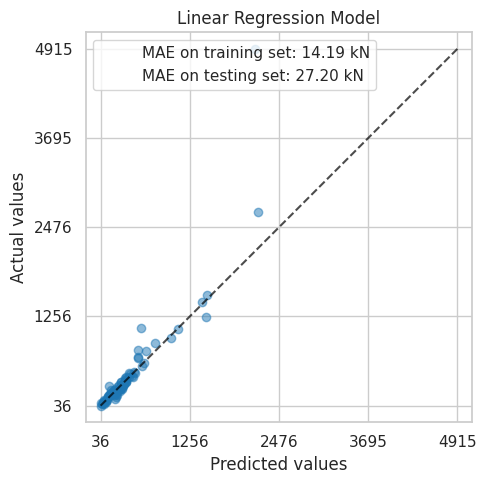

In [62]:
validate_mea(model,X_train,X_test,y_train,y_test)

In [64]:
# Delete this for GitHub - It will not work with the best Regressor
def validate_coefs(model, output='plot', standarise=False, X_train=None):
    feature_names = model[:-1].get_feature_names_out()

    coefs = pd.DataFrame(
        model[-1].coef_,
        columns=["Coefficients"],
        index=feature_names
    )

    if ((output=='plot') & (standarise==False)):
      coefs.plot.barh(figsize=(9, 7))
      plt.title("Linear Regression Model")
      plt.axvline(x=0, color=".5")
      plt.xlabel("Raw coefficient values")
      plt.subplots_adjust(left=0.3)

    elif ((output=='plot') & (standarise==True)):

      X_train_preprocessed = pd.DataFrame(
      model[:-1].transform(X_train), columns=feature_names
      )

      # Creating subplots
      fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 14))

      # First subplot: bar chart of standard deviation values
      X_train_preprocessed.std(axis=0).plot.barh(ax=ax1)
      ax1.set_title("Feature ranges")
      ax1.set_xlabel("Std. dev. of feature values")
      fig.subplots_adjust(left=0.3)

      # Second subplot: bar chart of adjusted coefficients
      coefs_2 = pd.DataFrame(
          model[-1].coef_ * X_train_preprocessed.std(axis=0),
          columns=["Coefficient importance"],
          index=feature_names,
      )
      coefs_2.plot(kind="barh", ax=ax2)
      ax2.set_title("Linear Regression Model")
      ax2.set_xlabel("Coefficient values corrected by the feature's std. dev.")
      ax2.axvline(x=0, color=".5")
      fig.subplots_adjust(left=0.3)

      # Show the plots
      plt.show()

    elif output=='table':
      return coefs

    else:
      raise ValueError('given output is false. Accepted is "plot" or "table"')

In [65]:
# validate_coefs(model,standarise=True,X_train=X_train) # Model not sufficent for this funtion

In [67]:
# Check the cross validation score on 5-folds
cvs = cross_val_score(model, X_test, y_test, cv=5)

print(f'Mean score: {cvs.mean():.2f}\nScore array:\n{np.round(cvs, 2)}')


Mean score: 0.80
Score array:
[0.63 0.87 0.86 0.96 0.67]


Model Prediction

In [74]:
# Example input data
sample_input = {
    'Shape': ['C'],             # Circular Column
    'davg (mm)': [121],         # Static slab high
    'fc (MPa)': [23.5],         # Concrete strength
    'fy (MPa)': [450],          # Reinforcement strength
    'bcp (mm)': [2165],         # Basic controll perimeter (it contains the information about column geometry!)
    'reinforcement_area (mm2)': [808] # Reinforement Area in the given bcp
}

# Converting the input data into a DataFrame
input_df = pd.DataFrame(sample_input)

# Making a prediction using the model
predictions = model.predict(input_df)

# Displaying the prediction result
print(f'Estimated Pu[kN]: {np.round(predictions,2)[0]}')


Estimated Pu[kN]: 276.29
